In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
train_df = pd.read_csv("train_dev_data/train_set.csv").dropna()
dev_df = pd.read_csv("train_dev_data/dev_set.csv").dropna()
X_train = train_df['text']
y_train = train_df['label']
X_test = dev_df['text']
y_test = dev_df['label']

In [7]:
# Convert text to numerical representation
vectorizer = TfidfVectorizer(stop_words='english')  # Use TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Train Naive Bayes on the resampled data
nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = nb_model.predict(X_test_tfidf)

In [8]:
import numpy as np

# Assuming 'vectorizer' is your TfidfVectorizer and 'nb_model' is your trained MultinomialNB
feature_names = vectorizer.get_feature_names_out()

# log probabilities for each class (0 = non-PCL, 1 = PCL)
class_log_probs = nb_model.feature_log_prob_

# Find the top words for PCL (class 1)
top_pcl_indices = np.argsort(class_log_probs[1])[-10:]
top_non_pcl_indices = np.argsort(class_log_probs[0])[-10:]

print("Top words indicating PCL:")
for i in top_pcl_indices:
    print(feature_names[i], class_log_probs[1][i])

print("\nTop words indicating Non-PCL:")
for i in top_non_pcl_indices:
    print(feature_names[i], class_log_probs[0][i])

Top words indicating PCL:
hopeless -6.168767907927502
said -5.898298924014176
hope -5.862377753671461
help -5.85248763535748
families -5.703744315621391
children -5.632547637461205
poor -5.623277396780691
homeless -5.607332618963791
people -5.579324713370331
need -5.4111804903432414

Top words indicating Non-PCL:
homeless -6.540133256642282
refugees -6.485708736694856
need -6.436064733820998
disabled -6.419781267560063
vulnerable -6.414398934202593
families -6.413972137734669
immigrants -6.281632619864657
people -6.194833649158339
women -6.182944420916919
said -6.018422001782316


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1894
           1       0.25      0.59      0.35       199

    accuracy                           0.79      2093
   macro avg       0.60      0.70      0.61      2093
weighted avg       0.88      0.79      0.83      2093

Confusion Matrix:
[[1541  353]
 [  81  118]]


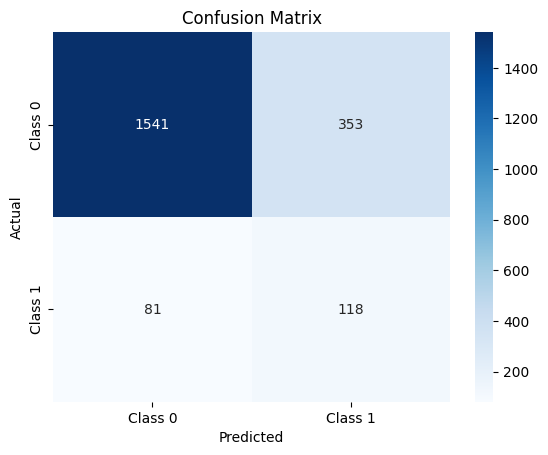

In [9]:
# Evaluate the model
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()